In [475]:
import os

import glob
import fitsio

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits as fits

import desispec.io
import redrock.templates

from   desisim.specsim        import  get_simulator
from   astropy.convolution    import  convolve, Box1DKernel
from   desispec.spectra       import  Spectra
from   desispec.resolution    import  Resolution

from   desispec.interpolation import  resample_flux

from   astropy.table          import  Table

# Foundations to 1004 desispec ticket:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

In [363]:
andes                   = '/global/cfs/cdirs/desi/spectro/redux/andes/'

os.environ['SPEC_PROD'] = andes
os.environ['DESIMODEL'] = '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.13.0' 

# Get a cframe for ELG SV0 tile (67230)

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

In [364]:
night      = '20200314'

tile       = 67230
petal      = 0

# 0th fiber in the petal.
fiber      = 0

# Get (calibrated) spectra and calibration data 

In [365]:
# For each camera.
frames     = {}
cframes    = {}

psfs       = {}
skies      = {} 

fluxcalibs = {}

for cam in ['g', 'r', 'z']:
  # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/tiles/67230/20200314/cframe-z9-00055382.fits  
  specpaths    = glob.glob('{}/tiles/{}/{}/cframe-{}{}-*.fits'.format(andes, tile, night, cam, petal))

  expids       = [x.split('-')[-1].replace('.fits', '') for x in specpaths]
        
  # E.g.  /global/cfs/cdirs/desi/spectro/redux/andes/exposures/20200315/00055590/sky-r8-00055590.fits
  # skies_path   = glob.glob('{}/exposures/{}/{}/sky-{}{}-{}.fits'.format(andes, tile, night, cam, petal))
    
  mjd_obs      = 0.0
    
  for i, specpath in enumerate(specpaths):
    dat        = fits.open(specpath)
    
    _          = dat[0].header['MJD-OBS']

    # Get the last in the night, for example.      
    if _ > mjd_obs:          
        cframes[cam]    = fitsio.FITS(specpath)
                
        expid           = expids[i]
        exptime         = dat[0].header['EXPTIME']
        
        fiberid         = cframes[cam]['FIBERMAP']['FIBER'][fiber]
        
        psfs[cam]       = fitsio.FITS('{}/exposures/{}/{}/psf-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        skies[cam]      = fitsio.FITS('{}/exposures/{}/{}/sky-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        # https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_CALIB/fluxcalib-CAMERA.html
        fluxcalibs[cam] = fitsio.FITS('{}/exposures/{}/{}/fluxcalib-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        frames[cam]     = fitsio.FITS('{}/exposures/{}/{}/frame-{}{}-{}.fits'.format(andes, night, expid, cam, petal, expid))
        
        mjd_obs         = dat[0].header['MJD-OBS']

# DESI sim. galaxy spectral templates 

In [367]:
def tracer_maker(wave=None, tracer='ELG', nmodel=1):
    if tracer == 'ELG':
        maker = desisim.templates.ELG(wave=wave)
                
    elif tracer == 'QSO':
        maker = desisim.templates.QSO(wave=wave)
    
    else:
        raise  ValueError('{} is not an available tracer.'.format(tracer))

    flux, wave, meta, objmeta = maker.make_templates(nmodel=nmodel)
        
    return  wave, flux, meta, objmeta     

In [368]:
camera                 = 'z'

In [369]:
wave                   = cframes[camera]['WAVELENGTH'][:]
_, flux, meta, objmeta = tracer_maker(wave=wave, tracer='ELG')

INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits


In [429]:
fflux                  = flux[fiber, :]
flux_ivar              = cframes[camera]['IVAR'][fiber, :]

res                    = cframes[camera]['RESOLUTION'][fiber,:,:]
mask                   = cframes[camera]['MASK'][fiber,:]

fibermap               = desispec.io.empty_fibermap(1) 

In [419]:
gmag = 22.5 - 2.5 * np.log10(meta['FLUX_G'][fiber])
rmag = 22.5 - 2.5 * np.log10(meta['FLUX_R'][fiber])
zmag = 22.5 - 2.5 * np.log10(meta['FLUX_Z'][fiber])

gmag, rmag, zmag

(22.582870488986373, 22.361717643216252, 21.60609744489193)

Text(0, 0.5, 'Observed flux [$10^{-17}$ erg/s/cm2/A)]')

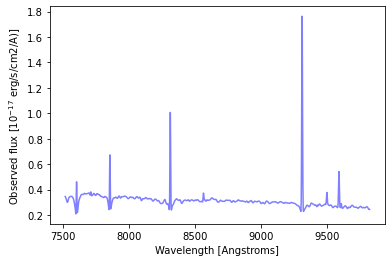

In [420]:
pl.plot(wave, fflux, c='b',    alpha=0.5)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [$10^{-17}$ erg/s/cm2/A)]')

Text(0, 0.5, 'Counts per Angstrom')

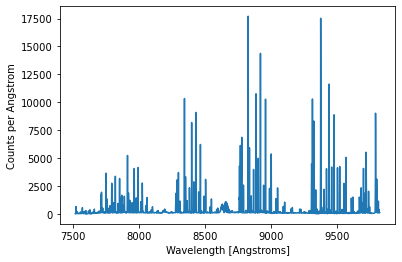

In [421]:
pl.plot(skies[camera]['WAVELENGTH'][:], skies[camera]['SKY'][fiber, :].T)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Counts per Angstrom')

In [422]:
# Includes seeing and airmass terms (therefore fiberloss).
fluxcalib = fluxcalibs[camera]['FLUXCALIB'][fiber,:]

In [423]:
uflux     = fflux * fluxcalib   # Uncalibrated flux [counts/Angstrom] 

## Calculate 'templateSNR' for a DESI spectrum when given a template, an EXPID and a FIBER-TILE-ID.

In [476]:
def templateSNR(template_flux, fluxcalib=None, flux_ivar=None):
    # dlambda per pixel = 0.8; 100A / dlambda per pixel = 125. 
    sflux  = convolve(template_flux, Box1DKernel(125)) 
 
    dflux  = flux - sflux 
 
    if fluxcalib is None:
        # Work in calibrated flux units.
        assert  flux_ivar is not None
        
        return  np.sum((dflux ** 2.) * flux_ivar)

    else: 
        # Work in uncalibrated flux units.
        dflux  *= fluxcalib
 
        result  = dflux * dflux

        # TBD.
        denom   = np.ones_like(result)
        
        result /= denom
        
        # Eqn. (1) of https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2
        return  np.sum(result)

In [479]:
FIBERTILEID = 10000 * tile + fiberid

print(tile, expid, fiberid, FIBERTILEID)

67230 00055382 0 672300000


In [480]:
print('Template SNR for the {} band is {}.]'.format(camera, templateSNR(fflux, fluxcalib=None, flux_ivar=flux_ivar)))

Template SNR for the z band is 30.31232313474115.]


##  Post-process spectra post redrock, calculate templateSNR for the redrock best-fit template.

First, run redshift fitting. 

In [384]:
# https://github.com/desihub/desisim/blob/c64ad6c14f36409833ad8616cb8ce180b1af54c1/py/desisim/scripts/quickspectra.py#L248

In [385]:
spec      = Spectra([camera], {camera: wave}, {camera: fflux[None, :]}, {camera: flux_ivar}, 
                     resolution_data={camera : res}, 
                     mask={camera : mask}, 
                     fibermap=fibermap, 
                     meta=None,
                     single=True)

In [386]:
desispec.io.write_spectra('/global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits', spec)  

'/global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits'

In [387]:
# https://github.com/desihub/tutorials/blob/master/simulating-desi-spectra.ipynb
zbest_file = os.path.join('/global/cscratch1/sd/mjwilson/desi/radweights/', 'test-zbest.fits')

In [431]:
cmd  = 'rrdesi {} --zbest {}'.format('/global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits', zbest_file)
srun = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
cmd  = '{} {} --mp 32'.format(srun, cmd)

print(cmd)

srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive rrdesi /global/cscratch1/sd/mjwilson/desi/radweights/spec_test.fits --zbest /global/cscratch1/sd/mjwilson/desi/radweights/test-zbest.fits --mp 32


Run on Cori Linux.  Finished?  Get the results.

In [481]:
zbest = Table.read(zbest_file, 'ZBEST')

In [482]:
zbest

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32
0,0.1012810468673706,118.60677429703631 .. 2.1036142971974714,0.9152815456943096,0.00017956067522297597,0,2824,GALAXY,,10,11.341802882030606,0,0


In [483]:
meta['REDSHIFT'][0], zbest['Z'][0]

(0.9152733, 0.9152815456943096)

In [484]:
# Import redrock templates
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [485]:
rr_z     = zbest['Z'][0]

spectype = zbest['SPECTYPE'][0].strip()
subtype  = zbest['SUBTYPE'][0].strip()

fulltype = (spectype, subtype)
ncoeff   = templates[fulltype].flux.shape[0]
coeff    = zbest['COEFF'][0][0:ncoeff]

In [486]:
rr_z, fulltype

(0.9152815456943096, ('GALAXY', ''))

In [487]:
tflux    = templates[fulltype].flux.T.dot(coeff)
twave    = templates[fulltype].wave * (1. + rr_z)

In [488]:
R        = Resolution(res[0])
txflux   = R.dot(resample_flux(wave, twave, tflux))

Text(0, 0.5, 'Observed flux [$10^{-17}$ erg/s/cm2/A)]')

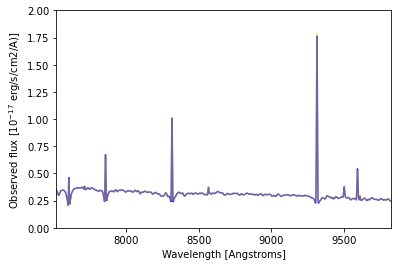

In [489]:
pl.plot(wave, fflux.T,  c='blue', alpha=0.9)
pl.plot(wave, txflux,   c='gold', alpha=0.4)

pl.xlim(wave[0], wave[-1])
pl.ylim(0.0, 2.0)

pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Observed flux [$10^{-17}$ erg/s/cm2/A)]')

In [490]:
print('Template SNR for the {} band is {}.]'.format(camera, templateSNR(fflux, fluxcalib=None, flux_ivar=flux_ivar)))

Template SNR for the z band is 30.31232313474115.]


In [491]:
print('RRTemplate SNR for the {} band is {}.]'.format(camera, templateSNR(txflux, fluxcalib=None, flux_ivar=flux_ivar)))

RRTemplate SNR for the z band is 30.28025238859542.]


In [492]:
dChi2         = zbest['DELTACHI2']

templatesnr   = templateSNR(fflux, fluxcalib=None, flux_ivar=flux_ivar)
rrtemplatesnr = templateSNR(txflux, fluxcalib=None, flux_ivar=flux_ivar)

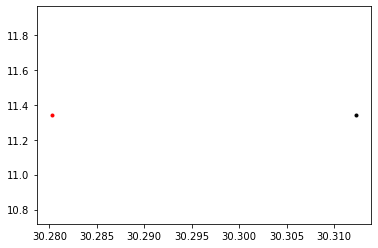

In [493]:
pl.plot(templatesnr,   dChi2, marker='.', c='k')
pl.plot(rrtemplatesnr, dChi2, marker='.', c='r')

##  Rad. weights

_Each tile, each fiber, a redshift efficiency as a function of redshift and target magnitude, per target class. This could be
for instance in the form of fits images in 3D (fiber x redshift x magnitude), with one HDU per target class, and one fits
file per tile_

In [511]:
hdr             = fits.open(specpath)[0].header

hdr['EXTNAME']  = 'RADWEIGHT'

primary         = fits.PrimaryHDU(header=hdr)

# LRG
lrg_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='LRG')

# ELG
elg_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='ELG')

# QSO
qso_radweight   = fits.ImageHDU(np.zeros((1, 25, 25)), name='QSO')

# List
all_hdus        = fits.HDUList([primary, lrg_radweight, elg_radweight, qso_radweight])

all_hdus.writeto('/global/cscratch1/sd/mjwilson/desi/radweights/lss_radweights.fits', overwrite=True)

In [512]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2881                                                  
NAXIS2  =                  500                                                  
EXTEND  =                    T                                                  
EXTNAME = 'RADWEIGHT'                                                           
OBSERVAT= 'KPNO    '           / Observatory name                               
OBS-LAT = '31.96403'           / [deg] Observatory latitude                     
OBS-LONG= '-111.59989'         / [deg] Observatory east longitude               
OBS-ELEV=                2097. / [m] Observatory elevation                      
TELESCOP= 'KPNO 4.0-m telescope' / Telescope name                               
INSTRUME= 'DESI    '        

## Done.